In [1]:
# run CW ODMR.
# control the frequency changes "manually" with the code here instead of using external trigger

In [1]:
%matplotlib inline

In [1]:
import nidaqmx
import numpy as np
import qt3rfsynthcontrol
import ctypes
import nidaqmx._lib  # Due to NIDAQmx C-API bug needed to bypass property getter (according to qudi)
import nidaqmx.stream_readers
import time
import matplotlib.pyplot as plt
import qcsapphire


In [31]:
nisys = nidaqmx.system.System()
device = nidaqmx.system.Device('Dev1')

In [30]:
list(nisys.tasks)

[]

In [32]:
device.reset_device()

In [3]:
#list(nisys.devices)

In [4]:
#device = nidaqmx.system.Device('Dev1')
#list(device.ao_physical_chans)
# list(device.ai_physical_chans)
#list(device.di_lines)
#list(device.do_lines)
#list(device.co_physical_chans)
#list(device.ci_physical_chans)

In [33]:
#Configure the NI DAQ

def configure_tasks(post_fix_task_name = None, 
                    device_name = 'Dev1',
                    clock_counter = 'ctr1',
                    edge_input_channel = 'PFI12',
                    edge_input_counter = 'ctr2',
                    clock_rate = 1000, 
                    N_data_samples_to_acquire = 500,
                    trigger_input = None):
   
    clock_task_name = f'sample_clock{post_fix_task_name}' 
    clock_task = nidaqmx.Task(clock_task_name)
       
    #this adds the clock signal to the output channel
    #is this necessary? 
    clock_task.co_channels.add_co_pulse_chan_freq(
            '/{0}/{1}'.format(device_name, clock_counter),
            freq=clock_rate,
            idle_state=nidaqmx.constants.Level.LOW)

    # clock_task.timing.cfg_implicit_timing(
    #     sample_mode=nidaqmx.constants.AcquisitionType.FINITE,
    #     samps_per_chan=n_steps+2) #qudi configures with n_steps + 1, should recheck why. suspicious extra "1" floating around (n_steps = 101)

    clock_task.timing.cfg_implicit_timing(
        sample_mode=nidaqmx.constants.AcquisitionType.CONTINUOUS,
        samps_per_chan=clock_rate) #qudi configures with n_steps + 1, should recheck why. suspicious extra "1" floating around (n_steps = 101)

    
    edge_detector_task_name = f'edge_input{post_fix_task_name}'

    edge_detector_task = nidaqmx.Task(edge_detector_task_name)

    #todo -- try to replace all of this with edge_detector_task.add_ci_count_edges_chan

    ctr_name = '/{0}/{1}'.format(device_name, edge_input_counter)
    edge_detector_task.ci_channels.add_ci_period_chan(
                        ctr_name,
                        min_val=0,
                        max_val=100000000,
                        units=nidaqmx.constants.TimeUnits.TICKS,
                        edge=nidaqmx.constants.Edge.RISING)

    # from qudi -- apparently this overcomes some kind of bug in the C-library, according to comments in qudi code
    
    chnl_name = '/{0}/{1}'.format(device_name, edge_input_channel)
    clock_channel = '/{0}InternalOutput'.format(clock_task.channel_names[0])

    try:
        nidaqmx._lib.lib_importer.windll.DAQmxSetCIPeriodTerm(
            edge_detector_task._handle,
            ctypes.c_char_p(ctr_name.encode('ascii')),
            ctypes.c_char_p(clock_channel.encode('ascii')))
        nidaqmx._lib.lib_importer.windll.DAQmxSetCICtrTimebaseSrc(
            edge_detector_task._handle,
            ctypes.c_char_p(ctr_name.encode('ascii')),
            ctypes.c_char_p(chnl_name.encode('ascii')))
    except:
        nidaqmx._lib.lib_importer.cdll.DAQmxSetCIPeriodTerm(
            edge_detector_task._handle,
            ctypes.c_char_p(ctr_name.encode('ascii')),
            ctypes.c_char_p(clock_channel.encode('ascii')))
        nidaqmx._lib.lib_importer.cdll.DAQmxSetCICtrTimebaseSrc(
            edge_detector_task._handle,
            ctypes.c_char_p(ctr_name.encode('ascii')),
            ctypes.c_char_p(chnl_name.encode('ascii')))

    if trigger_input:
        edge_detector_task.triggers.arm_start_trigger.trig_type =  nidaqmx.constants.TriggerType.DIGITAL_EDGE
        edge_detector_task.triggers.arm_start_trigger.dig_edge_edge =  nidaqmx.constants.Edge.RISING
        edge_detector_task.triggers.arm_start_trigger.dig_edge_src = f'/{device_name}/{trigger_input}'
    
    edge_detector_task.timing.cfg_implicit_timing(
        sample_mode=nidaqmx.constants.AcquisitionType.FINITE,
        samps_per_chan=N_data_samples_to_acquire)

    edge_detector_reader = nidaqmx.stream_readers.CounterReader(edge_detector_task.in_stream)
    
    return clock_task, edge_detector_task, edge_detector_reader



In [7]:
def run_once(detector_task, detector_reader, clock_rate,  N_samples,  read_write_timeout=10, pulser = None):
    detector_task.wait_until_done()
    detector_task.start()
    data_buffer = np.zeros(N_samples)
    
    if pulser:
        pulser.software_trigger()
    #time.sleep(1.1*N_samples / clock_rate) # need to wait for data to acquire
    read_samples = detector_reader.read_many_sample_double(
                            data_buffer,
                            number_of_samples_per_channel=N_samples,
                            timeout=read_write_timeout)
    detector_task.stop()
    try:
        assert read_samples == N_samples
    except Exception as e:
        print(e)
        print(f'{read_samples} != {N_samples}')
        raise e
        
    return data_buffer

In [16]:
rfsynth = qt3rfsynthcontrol.QT3SynthHD('COM5')

In [10]:
rfsynth.hw_info()

[('model_type', 'WFT SynthHD 1694'),
 ('serial_number', 1694),
 ('fw_version', 'Firmware Version 3.23'),
 ('hw_version', 'Hardware Version 2.06'),
 ('sub_version', 'HD')]

In [13]:
qcsapphire.discover_devices()

[['COM3',
  'Intel(R) Active Management Technology - SOL (COM3)',
  'PCI\\VEN_8086&DEV_43E3&SUBSYS_0A541028&REV_11\\3&11583659&1&B3'],
 ['COM5',
  'USB Serial Device (COM5)',
  'USB VID:PID=0483:A3E5 SER=206A36705430 LOCATION=1-2:x.0'],
 ['COM6',
  'USB Serial Device (COM6)',
  'USB VID:PID=04D8:000A SER= LOCATION=1-8:x.0'],
 ['COM7',
  'USB Serial Device (COM7)',
  'USB VID:PID=239A:8014 SER=3B0D07C25831555020312E341A3214FF LOCATION=1-6:x.0']]

In [14]:
p = qcsapphire.Pulser('COM6')

In [42]:
p.set_all_state_off()

In [46]:
## set up for software trigger pulses on channel B
p.pulse0.mode('single')
p.pulse0.period(0.0001) # 100 mus period
p.pulse0.external.mode('trigger')
p.pulse2.cmode('single')
p.pulse2.polarity('normal')
p.pulse2.width(0.000002) # 2 mus wide pulse

'ok'

In [54]:
freq_low = 2820e6
freq_high = 3130e6
freq_step = 10e6

N = 2
clock_rate = int(400e3) #400 kHz -- N = 2 samples, this is a 5 mu second window of data acquisition, equal to pulsed ODMR

try:
    clock_task, edge_detector_task, edge_detector_reader = configure_tasks(post_fix_task_name = 'v1', 
                                                                           clock_rate = clock_rate, 
                                                                           N_data_samples_to_acquire = N,
                                                                           edge_input_channel = 'PFI12',
                                                                           clock_counter = 'ctr1',
                                                                           trigger_input = 'PFI0')

    clock_task.start()

    data = {}
    rfsynth.rf_on(0)
    current_freq = freq_low
    step = 0
    
    p.pulse0.state(1)
    p.pulse2.state(1)

    while current_freq < freq_high:
        rfsynth.set_channel_fixed_output(0, -5.0, current_freq)
        data_at_one_freq = run_once(edge_detector_task, edge_detector_reader, clock_rate, N, read_write_timeout = 10, pulser = p)
        data[current_freq] = data_at_one_freq.sum()
        if step % 10 == 0:
            print(f'{current_freq/1e9} GHz: {data_at_one_freq.sum()}')
        current_freq += freq_step
        step += 1
except Exception as e:
    raise(e)
    
finally:
    
    try:
        rfsynth.rf_off(0)
        p.pulse0.state(0)
        p.pulse2.state(0)
    except Exception as e:
        print(e)
    
    try:
        clock_task.stop()
    except Exception as e:
        print(e)
    
    try:
        clock_task.close()
    except Exception as e:
        print(e)
    
    try:
        edge_detector_task.close()
    except Exception as e:
        print(e)

2.82 GHz: 5.0
2.92 GHz: 0.0
3.02 GHz: 3.0
3.12 GHz: 4.0


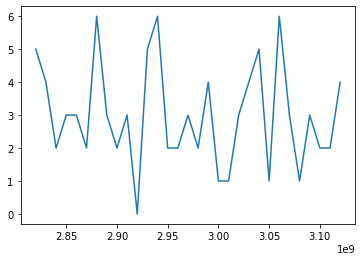

In [55]:
plt.plot(data.keys(), data.values())

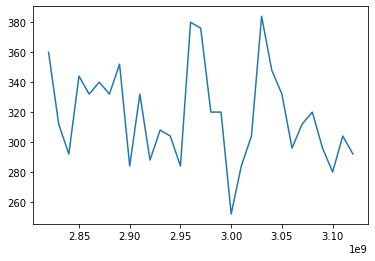

In [14]:
plt.plot(data.keys(), data.values())